# **Incels affiliation with the alt-right** | topic modeling with BERTopic

Project for *Network Science*, University of Padua, A.Y. 2022/23<br>

**Students** | Alberto Gobbin, Gianmarco Nagaro Quiroz, Daniele Ninni, Lorenzo Valentini

In [1]:
!apt update
!apt upgrade -y
!apt install build-essential -y
!pip install bertopic
!pip install wordcloud

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease               
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease             
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Fetched 114 kB in 0s (247 kB/s)    
Reading package lists... Done
Building dependency tree       
Reading state information... Done
1 package can be upgraded. Run 'apt list --upgradable' to see it.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Calculating upgrade... Done
The following packages have been kept back:
  libnccl2
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.8ubuntu1.1).
0 upgraded, 0 newly inst

In [2]:
import time
from shutil import make_archive

import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer

from cuml.manifold import UMAP   # GPU-accelerated UMAP
from cuml.cluster import HDBSCAN # GPU-accelerated HDBSCAN

from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance, KeyBERTInspired

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px

 ### Settings

In [3]:
norm            = False
fit_model        = False
smoke_test      = False
smoke_test_frac = 0.2

## 1 - Data

### 1.1 - Load data

In [4]:
data = {}
embeddings = {}

groups = [
    'incels',
    'altright',
    'leftwing'
    ]

for group in groups:

    data[group] = pd.read_csv(f'data_{group}_cleaned.csv', lineterminator='\n')
    data[group]['group'] = group
    
    embeddings[group] = np.load(f'embeddings_{group}{"_norm" if norm else ""}.npy')

data['incels']

,instance,author,body,title,subreddit,score,id,group
0,submission,ANgroupMOD,"dear subscribers, as you may know, we’ve gro...",Open call for moderator applications,antinatalism,71,yz7a7q,incels
1,comment,IPcreator,"enjoyed it, great job by both.",mechANized: Antinatalism & Open AI #2 Matti Hä...,antinatalism,1,j4ryie0,incels
2,comment,ArmsWindmill,“but who will take care of you when you’re old...,Imagine having ten children only to die alone ...,antinatalism,1,j4stojh,incels
3,comment,hypothetical_zombie,"someone, please tell me again how being cf mea...",Imagine having ten children only to die alone ...,antinatalism,1,j4stim1,incels
4,comment,Aurora1717,"""smith listed many things about her mother, in...",Imagine having ten children only to die alone ...,antinatalism,1,j4tcxyh,incels
...,...,...,...,...,...,...,...,...
774048,comment,ProbableError,as someone who has been married for quite some...,I don't think it's rude to ask who the father ...,unpopularopinion,1,j1no8bs,incels
774049,comment,smitbret,"because, in that situation, it's not rude to a...",I don't think it's rude to ask who the father ...,unpopularopinion,5,j18xcnh,incels
774050,comment,whiteshadow88,it’s not rude to wonder who 50% of the child i...,I don't think it's rude to ask who the father ...,unpopularopinion,4,j192d3a,incels
774051,comment,Level_Substance4771,"i haven’t reread the thread, but i was under t...",I don't think it's rude to ask who the father ...,unpopularopinion,1,j1lxi5v,incels


### 1.2 - Smoke test

In [5]:
smoke_test_threshold = 1000 # minimum length of reduced datasets

if smoke_test:

    len_min = smoke_test_frac * min([len(data[group]) for group in groups])
    if len_min < smoke_test_threshold:

        raise Exception(f'One of the reduced datasets would have a number of samples < {smoke_test_threshold}! Select a larger value for "smoke_test_frac".')

    else:
        
        for group in groups:

            data[group]       = data[group].sample(frac=smoke_test_frac, replace=False)
            embeddings[group] = embeddings[group][data[group].index]

### 1.3 - Documents

In [6]:
docs = pd.concat([data[group]['body'].astype('str') for group in groups], ignore_index=True)
docs

0          dear  subscribers,  as you may know, we’ve gro...
1                             enjoyed it, great job by both.
2          “but who will take care of you when you’re old...
3          someone, please tell me again how being cf mea...
4          "smith listed many things about her mother, in...
                                 ...                        
2001001    grow your own shit. companion planting alone c...
2001002    sick yeah i live in pa so lots of mennonites/a...
2001003    i wish i could :( but i live in an apartment i...
2001004    yeah same :(  i personally recommend  if you c...
2001005    here's a sneak peek of  using the [top posts](...
Name: body, Length: 2001006, dtype: object

### 1.4 - Embeddings

In [7]:
embeddings = np.vstack([embeddings[group] for group in groups])
embeddings.shape

(2001006, 384)

### 1.5 - Classes

In [8]:
classes = pd.concat([data[group]['group'] for group in groups], ignore_index=True)
classes

0            incels
1            incels
2            incels
3            incels
4            incels
             ...   
2001001    leftwing
2001002    leftwing
2001003    leftwing
2001004    leftwing
2001005    leftwing
Name: group, Length: 2001006, dtype: object

## 2 - Topic modeling

### 2.1 - BERTopic model training

In [9]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

if fit_model:

    # reduce dimensionality
    umap_model = UMAP(n_neighbors=15, n_components=5, metric='cosine')

    # cluster reduced embeddings
    hdbscan_model = HDBSCAN(min_cluster_size=15, min_samples=5, metric='euclidean', prediction_data=False)

    # tokenize topics
    vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english", min_df=0.01, max_df=0.99)

    # create topic representation
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

    # (optional) fine-tune topic representations with `bertopic.representation` models
    representation_models = [MaximalMarginalRelevance(diversity=0.3), KeyBERTInspired()]
    
    # initialize model
    topic_model = BERTopic(
        embedding_model      = embedding_model,
        umap_model           = umap_model,
        hdbscan_model        = hdbscan_model,
        vectorizer_model     = vectorizer_model,
        ctfidf_model          = ctfidf_model,
        representation_model = representation_models,
        language             = 'english',
        top_n_words          = 10,
        min_topic_size       = 500,
        nr_topics            = 'auto', # 'auto' for automatic topic reduction
        verbose              = True
    )
    
    # train model
    print('BERTopic model training ...')
    tic = time.time()
    topic_model.fit_transform(docs, embeddings)
    toc = time.time()
    print(f'DONE! Elapsed time:', f'{toc-tic:.2f}'.rjust(8), 'sec')
    
    # save model
    topic_model.save('bertopic_model')
    
else:
    
    # load model
    print('BERTopic model loading ... ', end='')
    tic = time.time()
    topic_model = BERTopic.load('bertopic_model_full')
    toc = time.time()
    print(f'DONE! Elapsed time:', f'{toc-tic:.2f}'.rjust(8), 'sec')

BERTopic model loading ... DONE! Elapsed time:    16.73 sec


### 2.2 - Get all topic information

In [10]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1341928,-1_struggles_supremacist_white supremacy_atheist
1,0,12458,0_vaccine_vaccines_vaccinated_vaccination
2,1,9709,1_putin_ukraine_soviet union_russia
3,2,8364,2_scripture_salvation_verse_forgiveness
4,3,7909,3_firearm_firearms_rifles_gun control
...,...,...,...
5271,5270,15,5270_removing_purge_remove_removed
5272,5271,15,5271_bullshit___
5273,5272,15,5272_whats_wtf_need know_
5274,5273,15,5273_women aren_women want_woman don_think dep...


### 2.3 - Reduce number of topics

In [11]:
#if fit_model:
#    topic_model.reduce_topics(docs, nr_topics=100)
#else:
#    topic_model = BERTopic.load('bertopic_model_full_100')

#topic_model.get_topic_info()

### 2.4 - Get most frequent topic information

In [12]:
topic_model.get_topic(0)

[('vaccine', 0.56867325),
 ('vaccines', 0.5674554),
 ('vaccinated', 0.554625),
 ('vaccination', 0.54312515),
 ('covid 19', 0.45387095),
 ('immunity', 0.4469548),
 ('pandemic', 0.36023602),
 ('flu', 0.34975922),
 ('immune', 0.3355602),
 ('infection', 0.33186287)]

### 2.5 - Get all document information

In [13]:
topic_model.get_document_info(docs)

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,"dear subscribers, as you may know, we’ve gro...",-1,-1_struggles_supremacist_white supremacy_atheist,struggles - supremacist - white supremacy - at...,0.000000,False
1,"enjoyed it, great job by both.",2723,2723_enjoyed_glad_im glad_great job,enjoyed - glad - im glad - great job - thanks ...,0.952094,True
2,“but who will take care of you when you’re old...,-1,-1_struggles_supremacist_white supremacy_atheist,struggles - supremacist - white supremacy - at...,0.000000,False
3,"someone, please tell me again how being cf mea...",-1,-1_struggles_supremacist_white supremacy_atheist,struggles - supremacist - white supremacy - at...,0.000000,False
4,"""smith listed many things about her mother, in...",-1,-1_struggles_supremacist_white supremacy_atheist,struggles - supremacist - white supremacy - at...,0.000000,False
...,...,...,...,...,...,...
2001001,grow your own shit. companion planting alone c...,-1,-1_struggles_supremacist_white supremacy_atheist,struggles - supremacist - white supremacy - at...,0.000000,False
2001002,sick yeah i live in pa so lots of mennonites/a...,817,817_civilized_anarchism_conservatism_empower,civilized - anarchism - conservatism - empower...,0.105739,False
2001003,i wish i could :( but i live in an apartment i...,-1,-1_struggles_supremacist_white supremacy_atheist,struggles - supremacist - white supremacy - at...,0.000000,False
2001004,yeah same :( i personally recommend if you c...,-1,-1_struggles_supremacist_white supremacy_atheist,struggles - supremacist - white supremacy - at...,0.000000,False


## 3 - Topic visualization

### 3.1 - Visualize topics

In [14]:
fig = topic_model.visualize_topics()

fig.write_html('fig/topics.html')
#fig.show()

### 3.2 - Visualize documents

In [15]:
if fit_model:
    reduced_embeddings = UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(embeddings)
else:
    reduced_embeddings = np.load('embeddings_2d_full.npy')

fig = topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=True)

fig.write_html('fig/docs_topics.html')
#fig.show()

### 3.3 - Visualize topic hierarchy

In [16]:
fig = topic_model.visualize_hierarchy(top_n_topics=30)

fig.write_html('fig/topic_hierarchy.html')
#fig.show()

### 3.4 - Visualize terms

In [17]:
fig = topic_model.visualize_barchart(top_n_topics=16)

fig.write_html('fig/terms.html')
#fig.show()

### 3.5 - Visualize topic similarity

In [18]:
fig = topic_model.visualize_heatmap(top_n_topics=100)

fig.write_html('fig/topic_similarity.html')
#fig.show()

In [19]:
adjacency_matrix = (fig.data[0]).z
adjacency_matrix.shape

(100, 100)

In [20]:
np.save('topics_adjacency_matrix', adjacency_matrix)

In [21]:
df = topic_model.get_document_info(docs)

df['Group'] = classes

df = df[(df['Topic'] < 100) & (df['Topic'] != -1)]
df = df[["Topic", "Group"]]

counts = df.groupby(['Topic']).count()['Group']

df = df.groupby(['Topic']).agg(pd.Series.mode)

group_to_color = {'incels':'blue', 'altright':'red', 'leftwing':'green'}

df['Color'] = df.replace({'Group': group_to_color})
df['Count'] = counts

df = df.reset_index()
df

,Topic,Group,Color,Count
0,0,altright,red,12458
1,1,altright,red,9709
2,2,altright,red,8364
3,3,altright,red,7909
4,4,incels,blue,6529
...,...,...,...,...
95,95,altright,red,1077
96,96,altright,red,1072
97,97,incels,blue,1067
98,98,leftwing,green,1058


In [22]:
df.to_csv('topics_df.csv', index=False)

### 3.6 - Visualize term score decline

In [23]:
fig = topic_model.visualize_term_rank()

fig.write_html('fig/term_score_decline.html')
#fig.show()

### 3.7 - Visualize topics per class

In [24]:
topics_per_class = topic_model.topics_per_class(docs, classes=classes)

fig = topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=30)

fig.write_html('fig/topics_per_class.html')
#fig.show()

3it [07:20, 146.80s/it]


### 3.8 - Visualize wordcloud for a specific topic

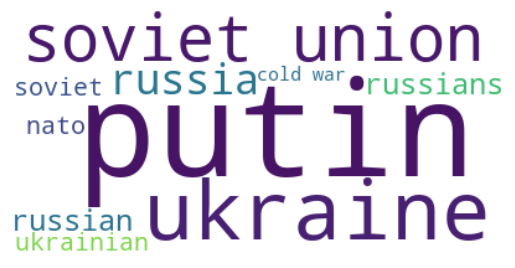

In [25]:
def create_wordcloud(model, topic):
    
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color='white', max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
# show wordcloud
create_wordcloud(topic_model, topic=1)

### 3.9 - Visualize documents per class

In [26]:
docs_topic = topic_model.get_document_info(docs).Topic
docs_repr  = topic_model.get_document_info(docs).Representative_document

topics_frac = 0.9

#### 3.9.1 - 2D embedding

In [27]:
if fit_model:
    
    embeddings_2d = UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(embeddings)
    
else:
    
    embeddings_2d = np.load('embeddings_2d_full.npy')

In [28]:
docs_2d = pd.DataFrame({
                    'x': embeddings_2d[:, 0],
                    'y': embeddings_2d[:, 1],
                    'group': classes,
                    'topic': docs_topic,
                    'representative': docs_repr
                    })

docs_2d = docs_2d[docs_2d['topic'] != -1]
docs_2d = docs_2d[docs_2d['topic'] < (topics_frac * docs_2d['topic'].max())]
docs_2d = docs_2d[docs_2d['representative'] == True]
docs_2d

,x,y,group,topic,representative
1,3.081121,3.577079,incels,2723,True
100,3.091554,2.248085,incels,1363,True
115,-9.512629,-16.803669,incels,1188,True
131,0.639561,22.355591,incels,1984,True
132,1.574413,-2.529613,incels,3186,True
...,...,...,...,...,...
2000783,13.934971,7.568726,leftwing,12,True
2000831,4.225533,-29.807566,leftwing,111,True
2000849,8.664688,-7.500927,leftwing,4404,True
2000855,21.252972,-20.247147,leftwing,1090,True


In [29]:
fig_2d = px.scatter(
                data_frame = docs_2d,
                x          = 'x',
                y          = 'y',
                color      = 'group',
                opacity    = .5,
                title      = "<b>Documents |</b> 2D Embedding",
                template   = 'plotly_white'
                )

fig_2d.update_xaxes(visible=False)
fig_2d.update_yaxes(visible=False)
fig_2d.write_html('fig/docs_2d.html')
#fig_2d.show()

#### 3.9.2 - 3D embedding

In [30]:
if fit_model:
    
    embeddings_3d = UMAP(n_neighbors=15, n_components=3, metric='cosine').fit_transform(embeddings)
    
else:
    
    embeddings_3d = np.load('embeddings_3d_full.npy')

In [31]:
docs_3d = pd.DataFrame({
                    'x': embeddings_3d[:, 0],
                    'y': embeddings_3d[:, 1],
                    'z': embeddings_3d[:, 2],
                    'group': classes,
                    'topic': docs_topic,
                    'representative': docs_repr
                    })

docs_3d = docs_3d[docs_3d['topic'] != -1]
docs_3d = docs_3d[docs_3d['topic'] < (topics_frac * docs_3d['topic'].max())]
docs_3d = docs_3d[docs_3d['representative'] == True]
docs_3d

,x,y,z,group,topic,representative
1,-3.089359,1.755949,-0.395821,incels,2723,True
100,-2.491993,0.930130,-1.414467,incels,1363,True
115,5.545822,10.406246,-77.965088,incels,1188,True
131,-44.524635,-87.366486,-0.762491,incels,1984,True
132,0.853391,-0.268745,-1.733790,incels,3186,True
...,...,...,...,...,...,...
2000783,12.079699,-2.297165,-7.295205,leftwing,12,True
2000831,-3.833300,-7.940598,-18.976181,leftwing,111,True
2000849,4.402806,7.143660,-7.914943,leftwing,4404,True
2000855,20.083113,14.453609,0.896535,leftwing,1090,True


In [32]:
fig_3d = px.scatter_3d(
                    data_frame = docs_3d,
                    x          = 'x',
                    y          = 'y',
                    z          = 'z',
                    color      = 'group',
                    opacity    = .5,
                    title      = "<b>Documents |</b> 3D Embedding",
                    template   = 'plotly_white'
                    )

fig_3d.write_html('fig/docs_3d.html')
#fig_3d.show()

In [33]:
make_archive('fig', 'zip', 'fig')

'/notebooks/fig.zip'